In [1]:
! pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.9 MB 192 kB/s 


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings

In [3]:
from sktime.datasets import load_airline

df = load_airline()
df = df.to_frame()
names = ['Period', 'Number of airline passengers']
new_names = ['period', 'number']
df = df.rename(columns={names[0]:new_names[0], names[1]:new_names[1]})

In [4]:
display(df)

,number
Period,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0
...,...
1960-08,606.0
1960-09,508.0
1960-10,461.0


In [5]:
df.describe()

,number
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(1337)

In [21]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(df['number'].values.reshape(-1, 1))

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = 90

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print(training_data.shape)
print(dataX.shape)
print(dataY.shape)
print(trainX.shape)
print(trainY.shape)

(144, 1)
torch.Size([139, 4, 1])
torch.Size([139, 1])
torch.Size([90, 4, 1])
torch.Size([90, 1])


In [11]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [30]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
import time
t = time.time()
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

print('\n########################### \n')
print(f'Training time: {time.time()-t:.4} seconds')

Epoch: 0, loss: 0.66541
Epoch: 100, loss: 0.01086
Epoch: 200, loss: 0.00665
Epoch: 300, loss: 0.00340
Epoch: 400, loss: 0.00279
Epoch: 500, loss: 0.00268
Epoch: 600, loss: 0.00258
Epoch: 700, loss: 0.00247
Epoch: 800, loss: 0.00237
Epoch: 900, loss: 0.00227
Epoch: 1000, loss: 0.00218
Epoch: 1100, loss: 0.00209
Epoch: 1200, loss: 0.00200
Epoch: 1300, loss: 0.00192
Epoch: 1400, loss: 0.00185
Epoch: 1500, loss: 0.00180
Epoch: 1600, loss: 0.00175
Epoch: 1700, loss: 0.00172
Epoch: 1800, loss: 0.00169
Epoch: 1900, loss: 0.00167

########################### 

Training time: 5.478 seconds


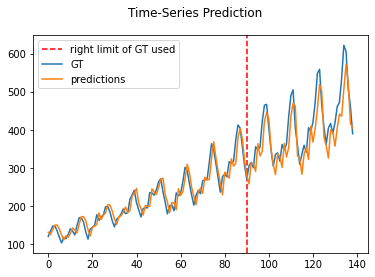

In [31]:
lstm.eval()

# predict on training and test data
all_predict = lstm(dataX)

data_predict = all_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of GT used')

plt.plot(dataY_plot, label='GT')
plt.plot(data_predict, label='predictions')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()
     

In [32]:
from sklearn.metrics import r2_score
r2_score(data_predict, dataY_plot)

0.9001603253472769